## Testcase
This test happens after the initial hdbscan hyper parameters optimization on a set of three variables, a few timeaggs, and a few lags, Dimensions have been reduced with both mean and spatcov. The ideas for the notebook are the following.
* check correctness of lagging
* check smoothness of the timeseries. Should differ over the timescales involved.
* check trends. Mean vs spatcov suffer differently?
* importance of mean vs spatcov. Dependent on size of the region?
* fit statistical models per mid-point lag vs per separation

In [116]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

In [2]:
basedir = Path('/scistor/ivm/jsn295/spatcov/')
precfile = basedir / 'precursor.multiagg.parquet'
predfile = basedir / 'response.multiagg.trended.parquet'

In [3]:
precs = pd.read_parquet(precfile)
preds = pd.read_parquet(predfile)

### Making sense of the time dimension
Left lag vs separation

Only after 1981 the data is complete. Before that swvl13 from ERA5-Land misses. After selecting the lags (left stamped) make sense. The amount of missing points at the beginning within one year (from March to August) due to lagging is as expected

In [28]:
precs.loc['1981-01-01':'1981-06-06',:].isnull().sum().groupby('lag').mean()

lag
-1      1
-13    13
-20    20
-26    26
-30    30
-31    31
-36    36
-37    37
-49    49
-60    60
-7      7
dtype: int64

In [26]:
precs.columns.droplevel([0,1,-2,-1]).drop_duplicates() # Unique lag, separation combinations. Basically no overlap. Perhaps at 

MultiIndex([( -7,  -8),
            ( -1,  -2),
            (-37, -44),
            (-26, -33),
            (-13, -20),
            ( -7, -14),
            (-60, -90),
            (-49, -79),
            (-36, -66),
            (-30, -60),
            (-31, -32),
            (-20, -21)],
           names=['lag', 'separation'])

### Statistical properties

In [117]:
# Some quality function? Extracting linear trend, stdev, smoothness (auto-corr)
def get_properties(series, submonths: list = None):
    """ submonths should be a list of integers 
    Returns a Series object
    """
    if not submonths is None:
        series = series.loc[series.index.month.map(lambda m: m in submonths)]
    std = series.std()
    mean = series.mean() 
    length = len(series)
    n_nan = series.isna().sum()
    series = series.dropna() # Remove nans
    lm = LinearRegression()
    lm.fit(y = scale(series), X = series.index.year.values.reshape(-1,1))
    trend = float(lm.coef_) # standardized coefficient / yr
    intercept = lm.intercept_
    # Smoothness is the autocorrelation at a lag of 1 day and 5 days.
    lag1 = pd.Series(series.values, index = series.index - pd.Timedelta('1D'), name = 'lag1')
    auto1 = pd.merge(left = series, right = lag1, left_index=True, right_index=True, how = 'inner').corr().iloc[0,-1]
    lag5 = pd.Series(series.values, index = series.index - pd.Timedelta('5D'), name = 'lag5')
    auto5 = pd.merge(left = series, right = lag5, left_index=True, right_index=True, how = 'inner').corr().iloc[0,-1]
    return(pd.Series({'std':std,'mean':mean,'length':length, 'n_nan':n_nan,'trend':trend, 'intercept':intercept, 'auto1': auto1, 'auto5': auto5}))

In [118]:
stats = precs.apply(get_properties, axis = 0)
stats

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were enc

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  war

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  war

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give 

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different l

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain to

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give 

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation o

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give 

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging betw

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different l

variable    z300_nhnorm                                                      \
timeagg               1                                                       
lag                 -7                                                  -1    
separation          -8                                                  -2    
clustid               0                         1                         0   
metric          spatcov         mean      spatcov         mean      spatcov   
std            2.961461  1143.392212    72.544029   494.251282   128.064819   
mean          -0.005349    14.853645    -0.019220    12.417463    -0.154643   
length      7544.000000  7544.000000  7544.000000  7544.000000  7544.000000   
n_nan        287.000000   287.000000   287.000000   287.000000    41.000000   
trend          0.001859     0.012267     0.005142     0.011832     0.008316   
intercept     -3.715154   -24.520842   -10.279520   -23.651197   -16.622971   
auto1          0.747379     0.917412     0.866337     0.895034     0.869988   
auto5          0.131501     0.385155     0.240398     0.307973     0.304691   

variable                swvl13_europe                                          \
timeagg                             7                                           
lag                               -37                                           
separation                        -44                                           
clustid                             0                          1                
metric             mean       spatcov         mean       spatcov         mean   
std          432.743134      0.000303     0.010829  6.510228e-05     0.019289   
mean          11.359239      0.000005    -0.000324 -3.697957e-07     0.000004   
length      7544.000000   7544.000000  7544.000000  7.544000e+03  7544.000000   
n_nan         41.000000   1811.000000  1811.000000  1.811000e+03  1811.000000   
trend          0.010459     -0.005596    -0.017754 -1.106092e-02     0.003197   
intercept    -20.907568     11.192057    35.508388  2.212184e+01    -6.393101   
auto1          0.909626      0.997687     0.998538  9.960446e-01     0.994795   
auto5          0.321620      0.948437     0.968418  9.160218e-01     0.885371   

variable    ...   sst_nhplus                                         \
timeagg     ...            1                                          
lag         ...          -1                                           
separation  ...          -2                                           
clustid     ...            0                         1                
metric      ...      spatcov         mean      spatcov         mean   
std         ...     0.002743     0.370910     0.022884     0.286223   
mean        ...    -0.000002    -0.013414    -0.000133    -0.008264   
length      ...  7544.000000  7544.000000  7544.000000  7544.000000   
n_nan       ...    41.000000    41.000000    41.000000    41.000000   
trend       ...     0.008387     0.028070     0.006915     0.035318   
intercept   ...   -16.765665   -56.111756   -13.823466   -70.600912   
auto1       ...     0.976912     0.986894     0.990853     0.991621   
auto5       ...     0.805647     0.886365     0.903484     0.914378   

variable                                                                     \
timeagg                                                                       
lag                                                                           
separation                                                                    
clustid               2                         3                         4   
metric          spatcov         mean      spatcov         mean      spatcov   
std            0.018569     0.314307     0.001479     0.573413     0.053132   
mean          -0.000481     0.003898     0.000021     0.032409     0.000653   
length      7544.000000  7544.000000  7544.000000  7544.000000  7544.000000   
n_nan         41.000000    41.000000    41.000000   

In [95]:
stats.loc[('auto1','auto5'),:].groupby(['variable','timeagg'], axis = 1).mean()

variable sst_nhplus                     swvl13_europe                      \
timeagg          1         30        7             1         30        7    
auto1      0.986360  0.999499  0.996218      0.991608  0.999357  0.997535   
auto5      0.880347  0.988607  0.929337      0.916238  0.984411  0.946833   

variable z300_nhnorm                      
timeagg           1         30        7   
auto1       0.867629  0.996022  0.968581  
auto5       0.281889  0.932590  0.529980

Regular inituitions seem confirmed. the longer the timescale the greater the auto-correlation. Z300 has the fastest decay. Then, sst, and then swvl. The latter order is a bit surprising. Though this mixes all regions. Lags do not really matter a lot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aabd8907a20>,
      dtype=object)

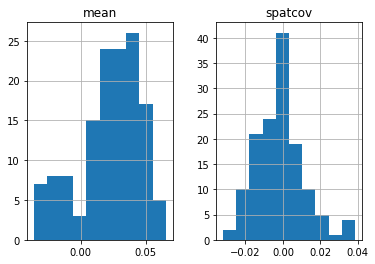

In [119]:
stats.loc['trend'].unstack(-1).hist()

The largest (standardized) trends seem to be in the mean, and are predominantly positive. Spatcov is distributed around zero.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import detrend

In [22]:
# Data
X = precs.loc[preds.index,(slice(None),slice(None),-7,slice(None))] # Training at lag -7. Single model
y = preds.iloc[:,2] # Output is the 5 daily average t2m (non-detrended I believe)
y_det = pd.Series(detrend(y), index  = y.index)

In [38]:
# Train a good RandomForest
# Check if we can do hyperparameter optimization.
from sklearn.model_selection import KFold
leaf_sizes = np.arange(1,800,20)
n_folds = 8
results = xr.DataArray(np.empty((len(leaf_sizes),n_folds,2)), dims = ('leaf_size','fold','metric'), coords = dict(leaf_size = leaf_sizes, fold = np.arange(n_folds),metric = ['r2','mse']))
for ind, alpha in enumerate(leaf_sizes):
    kf = KFold(n_splits=n_folds)
    k = 0
    for train_index, val_index in kf.split(X):
        X_t_fold, X_v_fold = X.iloc[train_index], X.iloc[val_index]
        y_t_fold, y_v_fold = y_det.iloc[train_index], y_det.iloc[val_index]
        regr = RandomForestRegressor(min_samples_leaf = alpha)
        regr.fit(X_t_fold,y_t_fold)
        predictions = regr.predict(X_v_fold)
        r2 = r2_score(y_v_fold, predictions)
        mse = mean_squared_error(y_v_fold, predictions)
        results[ind,k,:] = [r2, mse]
        k += 1

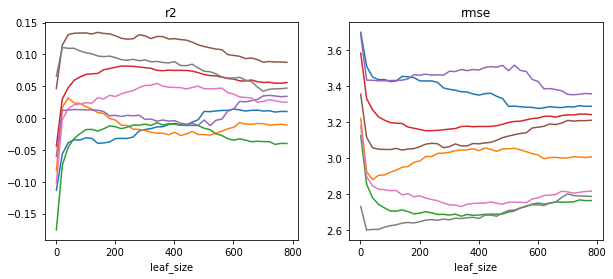

In [39]:
df = results.to_dataframe(name = 'score').unstack([1,2])
df.columns = df.columns.droplevel(0)
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize = (10,4))
df.loc[:,(slice(None),'r2')].plot(ax = ax1, legend = False, title = 'r2')
df.loc[:,(slice(None),'mse')].plot(ax = ax2, legend = False, title = 'rmse')

In [31]:
# So the model should have leaf_size = 200

regr_forest = RandomForestRegressor(min_samples_leaf = 200)
regr_forest.fit(X = X, y = y)

def single_pass_forward_permute(classifier, data_in, data_out, scores = [r2_score, mean_squared_error], scorenames = ['r2','mse']):
    outcomes = pd.DataFrame(index = data_in.columns, columns = pd.Index(scorenames,name = 'score'))
    for variable in data_in.columns:
        temp = data_in.copy() # Make sure that we are not overwriting by reference
        temp[variable] = temp[variable].sample(n = len(temp), replace = False).values
        prediction = classifier.predict(X = temp) # Prediction for positive, which is lightning
        outcomes.loc[variable] = [score(data_out, prediction) for score in scores]
    # Add the reference forecast:
    prediction = classifier.predict(X = data_in)
    outcomes.loc['reference'] = [score(data_out, prediction) for score in scores]
    return outcomes
train_perm = single_pass_forward_permute(regr_forest, X, y)

In [37]:
train_perm

score,r2,mse
"(z300_nhmin, 1, -7, 0)",0.101883,3.19245
"(z300_nhmin, 1, -7, 1)",-0.035663,3.68137
"(z300_nhmin, 1, -7, 2)",0.100565,3.19713
"(z300_nhmin, 1, -7, 3)",0.0659045,3.32033
reference,0.103219,3.18769
